# Solving MountainCar-v0 with PPO


In [5]:
from google.colab import drive
drive.mount('/content/drive')
save_path= "/content/drive/MyDrive/Collab Notebooks/"
#torch.save(model.state_dict(),

Mounted at /content/drive


The code comes from :
https://github.com/alanyuwenche/PPO_MountainCar-v0
I adapted it a bit and tuned a little the hyper parameters

In [3]:
# Imports

import os
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import random
import numpy as np
import gym

# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA L4


In [2]:
#PPO Action-Critic

class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []


    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, action_dim),
                        nn.Softmax(dim=-1)
                    )


        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, 1)
                    )

    def act(self, state):

        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()


    def evaluate(self, state, action):

        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy

class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def select_action(self, state):

        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob = self.policy_old.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)

        return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)


        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)


    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

print("============================================================================================")

def seed_torch(seed):
        torch.manual_seed(seed)
        if torch.backends.cudnn.enabled:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

####### initialize environment hyperparameters ######
env_name = "MountainCar-v0"
seed = 1
np.random.seed(seed)
random.seed(seed)
seed_torch(seed)

################ PPO hyperparameters ################
K_epochs = 40               # update policy for K epochs, ex. 5, 15, 30, 40, 80
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network
#####################################################

print("training environment name : " + env_name)

env = gym.make(env_name,new_step_api=True)

# state space dimension
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 64
################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip)

num_epochs = 50000
update_epoch = 5
maxR = -200
os.makedirs('./data/', exist_ok=True)
for i_episode in range(num_epochs):

    state = env.reset()
    current_ep_reward = 0

    for t in range(300):

        # select action with policy
        action = ppo_agent.select_action(state)
        # Use the new step API which returns 5 values
        state, reward, terminated, truncated, _ = env.step(action)
        # In the new API, 'done' is equivalent to 'terminated or truncated'
        done = terminated or truncated

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        current_ep_reward += reward

        if done:
            if i_episode % update_epoch == 0:
                ppo_agent.update()
            break



    if current_ep_reward > maxR:
      maxR = current_ep_reward
    if i_episode % 10 == 0:
      print("i_episode: ", i_episode, " current_ep_reward: ",current_ep_reward," maxR: ",maxR)

    if current_ep_reward > -110:
      fileN = './data/'+'E'+str(i_episode)+'_PPOMC_agent.pth'
      torch.save(ppo_agent.policy.actor.state_dict(),fileN)

Device set to : NVIDIA L4
training environment name : MountainCar-v0


AttributeError: module 'numpy' has no attribute 'bool8'

# Download the weights of the policy

In [160]:
!cp /content/data/E14265_PPOMC_agent.pth /content/drive/MyDrive/

In [7]:
print(os.getcwd())
os.chdir('/content/drive/MyDrive/')
print(os.getcwd())

/content
/content/drive/MyDrive


# Creation of the preference Datasets

In [13]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
np.bool8=bool


# 1) Device & env setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = gym.make('MountainCar-v0',new_step_api=True)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
hidden_dim = 64

# 2) Define policy architecture matching saved checkpoints
def make_policy():
    return nn.Sequential(
        nn.Linear(obs_dim, hidden_dim),  # "0.weight"/"0.bias"
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),  # "2.weight"/"2.bias"
        nn.Tanh(),
        nn.Linear(hidden_dim, act_dim),  # "4.weight"/"4.bias"
    ).to(device)

# 3) Load policies
def load_policy(path):
    policy = make_policy()
    ckpt = torch.load(path, map_location=device)
    policy.load_state_dict(ckpt)
    policy.eval()
    return policy

policy1 = load_policy('E18750_PPOMC_agent.pth')
policy2 = load_policy('/content/drive/MyDrive/data2/E9914_PPOMC_agent.pth')  # update path as needed

In [11]:
# 4) Generate single-episode trajectory for each policy
def generate_trajectory(policy, max_steps=1000):
    states, actions, rewards = [], [], []
    obs = env.reset()
    state = obs[0] if isinstance(obs, tuple) else obs
    for idx in range(max_steps):
        states.append(state)
        st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            logits = policy(st)
            action = Categorical(logits=logits).sample().item()
        actions.append(action)

        step_out = env.step(action)
        if len(step_out) == 5:           # new Gymnasium API
            next_obs, r, term, trunc, _ = step_out
            done = term or trunc
        else:                             # classic Gym
            next_obs, r, done, _ = step_out

        rewards.append(r)
        state = next_obs[0] if isinstance(next_obs, tuple) else next_obs

        if done:
            print(f"Episode finished at step {idx}, reward={r}")
            break

    return {
        'states':  np.array(states),
        'actions': np.array(actions),
        'rewards': np.array(rewards),
    }

traj1 = generate_trajectory(policy1)
traj2 = generate_trajectory(policy2)



Episode finished at step 110, reward=-1.0
Episode finished at step 183, reward=-1.0


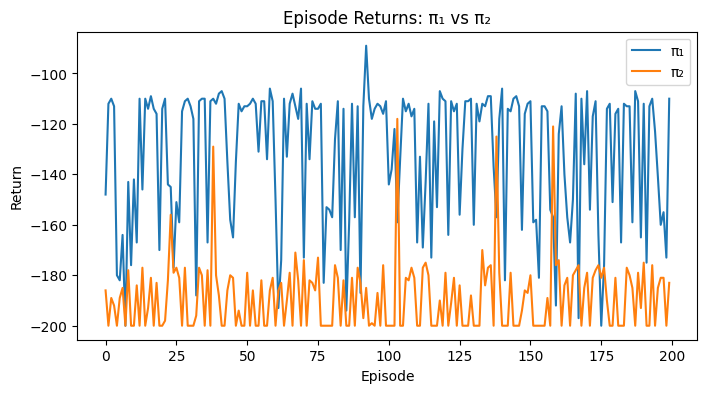

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
def collect_returns(policy, n_eps=200, max_steps=1000):
    returns = []
    for _ in range(n_eps):
        obs = env.reset()
        state = obs[0] if isinstance(obs, tuple) else obs
        total_r = 0
        done = False
        for _ in range(max_steps):
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(st)
                dist   = Categorical(logits=logits)
                action = dist.sample().item()
            step = env.step(action)
            if len(step) == 5:  # new Gymnasium API
                ns, r, term, trunc, _ = step
                done = term or trunc
            else:               # classic Gym
                ns, r, done, _ = step
            total_r += r
            state     = ns[0] if isinstance(ns, tuple) else ns
            if done:
                break
        returns.append(total_r)
    return returns

# 6) Collect & plot
rets1 = collect_returns(policy1)
rets2 = collect_returns(policy2)

plt.figure(figsize=(8,4))
plt.plot(rets1, label='π₁')
plt.plot(rets2, label='π₂')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Episode Returns: π₁ vs π₂')
plt.legend()
plt.show()


# 5) Build paired CSV
max_steps = min(len(traj1['states']), len(traj2['states']), 1000)
rows = []
for t in range(max_steps):
    rows.append({
        'state_pi1': traj1['states'][t].tolist(),
        'action_pi1': int(traj1['actions'][t]),
        'reward_pi1': float(traj1['rewards'][t]),
        'state_pi2': traj2['states'][t].tolist(),
        'action_pi2': int(traj2['actions'][t]),
        'reward_pi2': float(traj2['rewards'][t]),
    })

df = pd.DataFrame(rows)
df.to_csv('paired_trajectories.csv', index=False)

# 6) Download
files.download('paired_trajectories.csv')

# Violin Plot

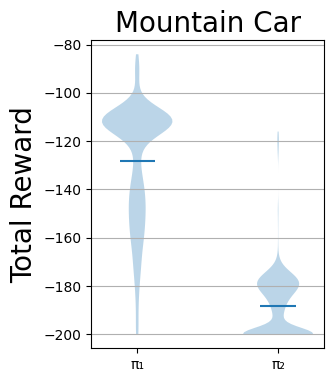

In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Ensure env and policies remain available in CPU mode
device = torch.device('cpu')
policy1.to(device)
policy2.to(device)

# Collect returns across seeds (on CPU)
n_eps = 1000
seeds = [0, 1, 2]
rets1_all, rets2_all = [], []

for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    env.reset(seed=seed)

    # collect_returns will run entirely on CPU now
    r1 = collect_returns(policy1, n_eps=n_eps, max_steps=1000)
    r2 = collect_returns(policy2, n_eps=n_eps, max_steps=1000)
    rets1_all.extend(r1)
    rets2_all.extend(r2)

# Violin plot
fig, ax = plt.subplots(figsize=(3,4))
parts = ax.violinplot([rets1_all, rets2_all], showmeans=True,showextrema=False)

ax.set_xticks([1, 2])
ax.set_xticklabels(['π₁', 'π₂'])
ax.yaxis.grid(True)
ax.set_ylabel('Total Reward', fontsize=20)
ax.set_title('Mountain Car', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()


# Preference Dataset Marc

In [16]:
import os, pickle
from torch.distributions import Categorical

# 1) Device & env
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env    = gym.make('MountainCar-v0')

# 2) Policy architecture + loader
def make_policy(obs_dim, act_dim, hidden_dim=64):
    return nn.Sequential(
        nn.Linear(obs_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, act_dim),
    ).to(device)

def load_policy(path, obs_dim, act_dim):
    policy = make_policy(obs_dim, act_dim)
    ckpt   = torch.load(path, map_location=device)
    policy.load_state_dict(ckpt)
    policy.eval()
    return policy

# 3) Get dims
tmp = gym.make('MountainCar-v0')
obs_dim = tmp.observation_space.shape[0]
act_dim = tmp.action_space.n
tmp.close()

# 4) Load checkpoints
policy1 = load_policy('E18750_PPOMC_agent.pth', obs_dim, act_dim)
policy2 = load_policy('PI2_R-110.pth',        obs_dim, act_dim)

# 5) Single-episode trajectory generator
def generate_trajectory(policy, max_steps=1000):
    states, actions, rewards = [], [], []
    obs = env.reset()
    state = obs if not isinstance(obs, tuple) else obs[0]
    for _ in range(max_steps):
        states.append(np.array(state, dtype=np.float32))
        st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            a = Categorical(logits=policy(st)).sample().item()
        actions.append(int(a))
        step = env.step(a)
        if len(step) == 5:            # new Gym API
            next_obs, r, term, trunc, _ = step
            done = term or trunc
        else:                          # classic Gym
            next_obs, r, done, _ = step
        rewards.append(float(r))
        state = next_obs if not isinstance(next_obs, tuple) else next_obs[0]
        if done:
            break
    return np.stack(states), np.array(actions), np.array(rewards)

# 6) Build list-of-lists
dataset = []
for i in range(1000):
    s1,a1,r1 = generate_trajectory(policy1)
    s2,a2,r2 = generate_trajectory(policy2)
    R1, R2  = r1.sum(), r2.sum()
    pref    = float(np.exp(R1)/(np.exp(R1)+np.exp(R2)))

    # append the exact structure your loop expects
    dataset.append([
        (s1, a1),   # traj1: tuple of (states, actions)
        (s2, a2),   # traj2
        pref        # preference float
    ])

os.makedirs('output', exist_ok=True)
with open('output/formatted_preference_dataset_1000.pkl', 'wb') as f:
    pickle.dump(dataset, f)

print("✔ Wrote 20 trajectory‐pairs to output/formatted_preference_dataset.pkl")



/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


✔ Wrote 20 trajectory‐pairs to output/formatted_preference_dataset.pkl


# Preference dataset Mik

In [242]:
def generate_trajectory(policy, max_steps=1000):
    states, actions, rewards = [], [], []
    obs = env.reset()
    state = obs if not isinstance(obs, tuple) else obs[0]
    for _ in range(max_steps):
        states.append(np.array(state, dtype=np.float32))
        st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            a = Categorical(logits=policy(st)).sample().item()
        actions.append(int(a))
        step = env.step(a)
        if len(step) == 5:            # new Gym API
            next_obs, r, term, trunc, _ = step
            done = term or trunc
        else:                          # classic Gym
            next_obs, r, done, _ = step
        rewards.append(float(r))
        state = next_obs if not isinstance(next_obs, tuple) else next_obs[0]
        if done:
            break
    return np.array(states), np.array(actions), np.array(rewards)


num_traj = [15,25,50,100,200]

for num in num_traj:

  trajectories1 = [generate_trajectory(policy1) for _ in range(num)]
  trajectories2 = [generate_trajectory(policy2) for _ in range(num)]

  # 5) Build paired rows for each trajectory index
  rows = []
  for traj_id in range(num):
      t1 = trajectories1[traj_id]
      t2 = trajectories2[traj_id]
      L = min(len(t1[0]), len(t2[0]))
      for step in range(L):
          rows.append({
              'traj_id': traj_id,
              'step': step,
              'state': t1[0][step].tolist(),
              'action_plus': int(t1[1][step]),   # from policy1
              'action_minus': int(t2[1][step])   # from policy2
          })

  # 6) Save to CSV and download
  df_pairs = pd.DataFrame(rows)
  df_pairs.to_csv(f'paired_{num}_traj_pi1_pi2.csv', index=False)
  files.download(f'paired_{num}_traj_pi1_pi2.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [241]:
df=df_pairs.groupby('traj_id')[["state","action_plus","action_minus"]].agg(list)
df.to_csv('state_action_pairs.csv')
df.head()

,state,action_plus,action_minus
traj_id,,,
0,"[[-0.4208649694919586, 0.0], [-0.4226233363151...","[0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...","[0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, ..."
1,"[[-0.5243629217147827, 0.0], [-0.5233571529388...","[2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, ..."
2,"[[-0.4090845286846161, 0.0], [-0.4109266102313...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[-0.45354434847831726, 0.0], [-0.455065876245...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[[-0.4287613332271576, 0.0], [-0.4304630756378...","[0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


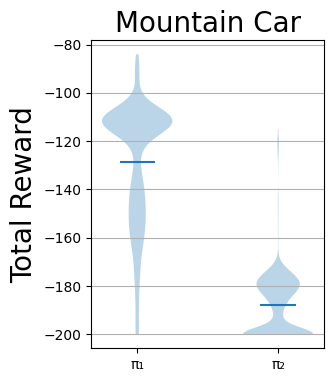

# Preference dataset mick

In [ ]:
# 1) Install & import

import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from google.colab import files

# 2) Device & env setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = gym.make('MountainCar-v0')
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
hidden_dim = 64

# 3) Define a bare nn.Sequential policy to match your saved state_dict keys
def make_policy():
    return nn.Sequential(
        nn.Linear(obs_dim, hidden_dim),  # key "0.weight"/"0.bias"
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),# key "2.weight"/"2.bias"
        nn.Tanh(),
        nn.Linear(hidden_dim, act_dim),  # key "4.weight"/"4.bias"
    ).to(device)

# 4) Load two policies from disk
def load_policy(path):
    policy = make_policy()
    ckpt = torch.load(path, map_location=device)
    policy.load_state_dict(ckpt)
    policy.eval()
    return policy

policy1 = load_policy('E18750_PPOMC_agent.pth')
policy2 = load_policy('E14265_PPOMC_agent.pth')  # update path

# 5) Function to collect returns per episode
def collect_returns(policy, n_eps=200, max_steps=1000):
    returns = []
    for _ in range(n_eps):
        obs = env.reset()
        state = obs[0] if isinstance(obs, tuple) else obs
        total_r = 0
        done = False
        for _ in range(max_steps):
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(st)
                dist   = Categorical(logits=logits)
                action = dist.sample().item()
            step = env.step(action)
            if len(step) == 5:  # new Gymnasium API
                ns, r, term, trunc, _ = step
                done = term or trunc
            else:               # classic Gym
                ns, r, done, _ = step
            total_r += r
            state     = ns[0] if isinstance(ns, tuple) else ns
            if done:
                break
        returns.append(total_r)
    return returns

# 6) Collect & plot
rets1 = collect_returns(policy1)
rets2 = collect_returns(policy2)

plt.figure(figsize=(8,4))
plt.plot(rets1, label='π₁')
plt.plot(rets2, label='π₂')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Episode Returns: π₁ vs π₂')
plt.legend()
plt.show()

# 7) Regenerate trajectories for π₁ (to match preference indices)
def generate_trajectories(policy, n_eps=200, max_steps=1000):
    trajs = []
    for _ in range(n_eps):
        obs = env.reset()
        state = obs[0] if isinstance(obs, tuple) else obs
        states, actions = [], []
        done = False
        for _ in range(max_steps):
            states.append(state)
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(st)
                dist   = Categorical(logits=logits)
                action = dist.sample().item()
            step = env.step(action)
            if len(step) == 5:
                ns, r, term, trunc, _ = step
                done = term or trunc
            else:
                ns, r, done, _ = step
            actions.append(action)
            state = ns[0] if isinstance(ns, tuple) else ns
            if done:
                break
        trajs.append({'states': np.array(states), 'actions': np.array(actions)})
    return trajs

trajectories = generate_trajectories(policy1)

# 8) Load preference CSV and build list of [(state,action)+, (state,action)-]
df = pd.read_csv('preference_dataset.csv')
preference_list = []
for _, row in df.iterrows():
    i, j, pref = int(row.traj_i_idx), int(row.traj_j_idx), int(row.preference)
    traj_i, traj_j = trajectories[i], trajectories[j]
    sa_i = list(zip(traj_i['states'], traj_i['actions']))
    sa_j = list(zip(traj_j['states'], traj_j['actions']))
    if pref == 0:
        preference_list.append([sa_i, sa_j])  # i preferred over j
    else:
        preference_list.append([sa_j, sa_i])  # j preferred over i

# 9) Inspect a few examples
for idx, (pos, neg) in enumerate(preference_list[:3]):
    print(f"Pair {idx}: +({len(pos)} steps), -({len(neg)} steps)")

import json
import pandas as pd

# preference_list: List of [traj_pos, traj_neg], where each traj is [(state,action), ...]
# e.g. preference_list[0] = [ [(s0,a0), (s1,a1),...], [(t0,b0),(t1,b1),...] ]

rows = []
for traj_pos, traj_neg in preference_list:
    # split states/actions and convert to plain lists
    states_pos = [s.tolist() for s,a in traj_pos]
    actions_pos = [int(a) for s,a in traj_pos]
    states_neg = [s.tolist() for s,a in traj_neg]
    actions_neg = [int(a) for s,a in traj_neg]
    rows.append({
        'states_pos': json.dumps(states_pos),
        'actions_pos': json.dumps(actions_pos),
        'states_neg': json.dumps(states_neg),
        'actions_neg': json.dumps(actions_neg),
    })

# build dataframe and save
df_pref = pd.DataFrame(rows)
df_pref.to_csv('preference_trajectories2.csv', index=False)

# download
from google.colab import files
files.download('preference_trajectories2.csv')



In [152]:
import json
import pandas as pd
from google.colab import files

# 1) Load your trajectory‐level CSV
df = pd.read_csv('preference_trajectories.csv')

flat_rows = []
for _, row in df.iterrows():
    states_pos  = json.loads(row['states_pos'])
    actions_pos = json.loads(row['actions_pos'])
    states_neg  = json.loads(row['states_neg'])
    actions_neg = json.loads(row['actions_neg'])
    pref        = row.get('preference', None)  # if you logged this

    # align on the shorter trajectory
    L = min(len(states_pos), len(states_neg))
    for t in range(L):
        flat_rows.append({
            'state': states_pos[t],
            'action_pos': actions_pos[t],
            'action_neg': actions_neg[t],
            'preference': pref
        })

# 2) Build DataFrame and save
flat_df = pd.DataFrame(flat_rows)
flat_df.to_csv('state_action_preference.csv', index=False)

# 3) Download
files.download('state_action_preference.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [150]:
flat_df.head(5)

,state,action_pos,action_neg,preference
0,"[-0.4160414934158325, 0.0]",0,1,None
1,"[-0.41783422231674194, -0.0017927541630342603]",1,2,None
2,"[-0.4204069674015045, -0.002572745317593217]",1,1,None
3,"[-0.4237413704395294, -0.0033343809191137552]",0,2,None
4,"[-0.42881351709365845, -0.005072159692645073]",0,2,None


# Other attempt to generate a better $\pi_2$

In [166]:
import os
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import random
import numpy as np
import gym

# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []


    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, action_dim),
                        nn.Softmax(dim=-1)
                    )


        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, 1)
                    )

    def act(self, state):

        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()


    def evaluate(self, state, action):

        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy

class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def select_action(self, state):

        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob = self.policy_old.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)

        return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)


        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)


    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

print("============================================================================================")

def seed_torch(seed):
        torch.manual_seed(seed)
        if torch.backends.cudnn.enabled:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

####### initialize environment hyperparameters ######
env_name = "MountainCar-v0"
seed = 1
np.random.seed(seed)
random.seed(seed)
seed_torch(seed)

################ PPO hyperparameters ################
K_epochs = 40               # update policy for K epochs, ex. 5, 15, 30, 40, 80
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network
#####################################################

print("training environment name : " + env_name)

env = gym.make(env_name,new_step_api=True)

# state space dimension
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 64
################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip)

num_epochs = 50000
update_epoch = 5
maxR = -200
os.makedirs('./data2/', exist_ok=True)
for i_episode in range(num_epochs):

    state = env.reset()
    current_ep_reward = 0

    for t in range(300):

        # select action with policy
        action = ppo_agent.select_action(state)
        # Use the new step API which returns 5 values
        state, reward, terminated, truncated, _ = env.step(action)
        # In the new API, 'done' is equivalent to 'terminated or truncated'
        done = terminated or truncated

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        current_ep_reward += reward

        if done:
            if i_episode % update_epoch == 0:
                ppo_agent.update()
            break



    if current_ep_reward > maxR:
      maxR = current_ep_reward
    if i_episode % 10 == 0:
      print("i_episode: ", i_episode, " current_ep_reward: ",current_ep_reward," maxR: ",maxR)
    if current_ep_reward >-160:
      fileN = './data2/'+'E'+str(i_episode)+'_PPOMC_agent.pth'
      torch.save(ppo_agent.policy.actor.state_dict(),fileN)

Device set to : NVIDIA L4
training environment name : MountainCar-v0
i_episode:  0  current_ep_reward:  -200.0  maxR:  -200
i_episode:  10  current_ep_reward:  -200.0  maxR:  -200
i_episode:  20  current_ep_reward:  -200.0  maxR:  -200
i_episode:  30  current_ep_reward:  -200.0  maxR:  -200
i_episode:  40  current_ep_reward:  -200.0  maxR:  -200
i_episode:  50  current_ep_reward:  -200.0  maxR:  -200
i_episode:  60  current_ep_reward:  -200.0  maxR:  -200
i_episode:  70  current_ep_reward:  -200.0  maxR:  -200
i_episode:  80  current_ep_reward:  -200.0  maxR:  -200
i_episode:  90  current_ep_reward:  -200.0  maxR:  -200
i_episode:  100  current_ep_reward:  -200.0  maxR:  -200
i_episode:  110  current_ep_reward:  -200.0  maxR:  -200
i_episode:  120  current_ep_reward:  -200.0  maxR:  -200
i_episode:  130  current_ep_reward:  -200.0  maxR:  -200
i_episode:  140  current_ep_reward:  -200.0  maxR:  -200
i_episode:  150  current_ep_reward:  -200.0  maxR:  -200
i_episode:  160  current_ep_re

KeyboardInterrupt: 